In [1]:
# Run this if your data is in Google Drive. If your files are already in /content/DEEPVISION, skip.
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive


/content/drive/MyDrive


In [7]:
!ls -lh

total 3.2G
drwx------ 2 root root 4.0K Nov 28 07:25 'Colab Notebooks'
-rw------- 1 root root 3.2G Nov 28 07:09  DEEPVISION.zip


In [8]:
!unzip -q DEEPVISION.zip -d /content

In [9]:
!ls /content

DEEPVISION  drive  sample_data


In [10]:
!find /content/DEEPVISION -type f -iname "*.jpg" | wc -l
!find /content/DEEPVISION -type f -iname "*.npy" | wc -l

1201
332


In [11]:
!find /content/DEEPVISION -type d -maxdepth 5 | sort

find: warning: you have specified the global option -maxdepth after the argument -type, but global options are not positional, i.e., -maxdepth affects tests specified before it as well as those specified after it.  Please specify global options before other arguments.
/content/DEEPVISION
/content/DEEPVISION/DATA
/content/DEEPVISION/DATA/processed
/content/DEEPVISION/DATA/processed/part_A
/content/DEEPVISION/DATA/processed/part_A/density
/content/DEEPVISION/DATA/ShanghaiTech
/content/DEEPVISION/DATA/ShanghaiTech/part_A
/content/DEEPVISION/DATA/ShanghaiTech/part_A/test_data
/content/DEEPVISION/DATA/ShanghaiTech/part_A/test_data/ground-truth
/content/DEEPVISION/DATA/ShanghaiTech/part_A/test_data/images
/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data
/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/ground-truth
/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images
/content/DEEPVISION/DATA/ShanghaiTech/part_B
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data
/co

In [14]:
!echo "---- IMAGES ----"
!find /content/DEEPVISION -type f -iname "*.jpg" | head -20

!echo "---- NPY ----"
!find /content/DEEPVISION -type f -iname "*.npy" | head -20

---- IMAGES ----
/content/DEEPVISION/venv/Lib/site-packages/matplotlib/mpl-data/sample_data/grace_hopper.jpg
/content/DEEPVISION/venv/Lib/site-packages/sklearn/datasets/images/china.jpg
/content/DEEPVISION/venv/Lib/site-packages/sklearn/datasets/images/flower.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_2.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_207.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_17.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_93.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_41.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_114.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_267.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_32.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_199.jpg
/content/DEEPVISION/DATA/ShanghaiTech/part_B/test_data/images/IMG_264.jpg
/c

In [17]:
# Paths for your dataset
IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"

# Check both exist and count files
import os

print("Images folder exists:", os.path.exists(IMG_DIR))
print("Density folder exists:", os.path.exists(DEN_DIR))

print("Images count:", len([f for f in os.listdir(IMG_DIR) if f.endswith(".jpg")]))
print("Density maps count:", len([f for f in os.listdir(DEN_DIR) if f.endswith(".npy")]))

Images folder exists: True
Density folder exists: True
Images count: 300
Density maps count: 300


In [16]:
!find /content/DEEPVISION -type d -iname "*density*"

/content/DEEPVISION/DATA/processed/part_A/density


In [19]:
!pip install torch torchvision opencv-python

In [24]:
class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_dir = img_dir
        self.den_dir = den_dir

        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.dens   = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])

        assert len(self.images) == len(self.dens), "Image–Density count mismatch!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        den_path = os.path.join(self.den_dir, self.dens[idx])

        # Load image → 512x512
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)

        # Load density → MUST BE 32x32
        den = np.load(den_path).astype(np.float32)
        den = cv2.resize(den, (32, 32))
        den = torch.tensor(den).unsqueeze(0)

        return img, den

In [25]:
from torch.utils.data import DataLoader

ds = CrowdDataset(IMG_DIR, DEN_DIR)
train_loader = DataLoader(ds, batch_size=2, shuffle=True)

print("Total training samples:", len(ds))

Total training samples: 300


In [26]:
import torch.nn as nn
from torchvision.models import vgg16

class CrowdCounter(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.features = nn.Sequential(*list(vgg.features.children())[:30])

        self.regressor = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 50

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0

    for imgs, dens in train_loader:
        imgs = imgs.to(device)
        dens = dens.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, dens)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch}/{EPOCHS}  Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "model_epoch_50.pth")
print("Saved model_epoch_50.pth")

Epoch 1/50  Loss: 0.0168
Epoch 2/50  Loss: 0.0028
Epoch 3/50  Loss: 0.0019
Epoch 4/50  Loss: 0.0017
Epoch 5/50  Loss: 0.0015
Epoch 6/50  Loss: 0.0014
Epoch 7/50  Loss: 0.0013
Epoch 8/50  Loss: 0.0012
Epoch 9/50  Loss: 0.0012
Epoch 10/50  Loss: 0.0011
Epoch 11/50  Loss: 0.0011
Epoch 12/50  Loss: 0.0011
Epoch 13/50  Loss: 0.0010
Epoch 14/50  Loss: 0.0010
Epoch 15/50  Loss: 0.0010
Epoch 16/50  Loss: 0.0010
Epoch 17/50  Loss: 0.0010
Epoch 18/50  Loss: 0.0009
Epoch 19/50  Loss: 0.0009
Epoch 20/50  Loss: 0.0009
Epoch 21/50  Loss: 0.0009
Epoch 22/50  Loss: 0.0009
Epoch 23/50  Loss: 0.0009
Epoch 24/50  Loss: 0.0009
Epoch 25/50  Loss: 0.0009
Epoch 26/50  Loss: 0.0009
Epoch 27/50  Loss: 0.0008
Epoch 28/50  Loss: 0.0008
Epoch 29/50  Loss: 0.0009
Epoch 30/50  Loss: 0.0008
Epoch 31/50  Loss: 0.0008
Epoch 32/50  Loss: 0.0008
Epoch 33/50  Loss: 0.0008
Epoch 34/50  Loss: 0.0008
Epoch 35/50  Loss: 0.0008
Epoch 36/50  Loss: 0.0008
Epoch 37/50  Loss: 0.0008
Epoch 38/50  Loss: 0.0008
Epoch 39/50  Loss: 0.

In [28]:
# confirm dataset & any checkpoint
import os
IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"
print("Images exist:", os.path.exists(IMG_DIR), "count:", len(os.listdir(IMG_DIR)) if os.path.exists(IMG_DIR) else 0)
print("Density exist:", os.path.exists(DEN_DIR), "count:", len(os.listdir(DEN_DIR)) if os.path.exists(DEN_DIR) else 0)
print("Any checkpoint files here?")
for f in os.listdir("/content"):
    if "model_epoch" in f or f.endswith(".pth"):
        print(" -", f)
# also check drive output if you saved there:
DR = "/content/drive/MyDrive"
if os.path.exists(DR):
    for f in os.listdir(DR):
        if f.endswith(".pth") or "model_epoch" in f:
            print("Drive:",f)

Images exist: True count: 300
Density exist: True count: 300
Any checkpoint files here?
Drive: model_epoch_50.pth


In [30]:
# ---------- TRAIN FROM SCRATCH FOR 100 EPOCHS ----------
import os, cv2, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16
from tqdm import tqdm

IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_dir, self.den_dir = img_dir, den_dir
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.dens   = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])
        self.pairs = [(os.path.join(img_dir, os.path.splitext(f)[0]+'.jpg'),
                       os.path.join(den_dir, os.path.splitext(f)[0]+'.npy'))
                      for f in self.images if os.path.splitext(f)[0]+'.npy' in self.dens]
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        imgp, denp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(imgp), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512)).astype('float32')/255.0
        img = torch.from_numpy(img).permute(2,0,1)
        den = np.load(denp).astype('float32')
        den = cv2.resize(den, (32,32))
        den = torch.from_numpy(den).unsqueeze(0)
        return img, den

ds = CrowdDataset(IMG_DIR, DEN_DIR)
loader = DataLoader(ds, batch_size=2, shuffle=True, num_workers=0)

# simple CSRNet-like model
class CrowdCounter(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(vgg.features.children())[:23])
        self.regressor = nn.Sequential(
            nn.Conv2d(512,256,3,padding=1), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=1), nn.ReLU(),
            nn.Conv2d(128,1,1)
        )
    def forward(self,x):
        x = self.backbone(x)
        x = self.regressor(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    model.train()
    total=0.0
    for imgs, dens in loader:
        imgs = imgs.to(device); dens = dens.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        if preds.shape[-2:] != dens.shape[-2:]:
            dens = torch.nn.functional.interpolate(dens, size=preds.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(preds, dens)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch}/{EPOCHS}  AvgLoss:{total/len(loader):.6f}")
    if epoch%10==0 or epoch==EPOCHS:
        torch.save(model.state_dict(), f"/content/model_epoch_{epoch}.pth")
        print("Saved checkpoint:", f"/content/model_epoch_{epoch}.pth")

# final save (redundant)
torch.save(model.state_dict(), "/content/model_epoch_100.pth")
print("Final model saved: /content/model_epoch_100.pth")

Epoch 1/100  AvgLoss:0.000505
Epoch 2/100  AvgLoss:0.000048
Epoch 3/100  AvgLoss:0.000020
Epoch 4/100  AvgLoss:0.000013
Epoch 5/100  AvgLoss:0.000009
Epoch 6/100  AvgLoss:0.000008
Epoch 7/100  AvgLoss:0.000007
Epoch 8/100  AvgLoss:0.000007
Epoch 9/100  AvgLoss:0.000006
Epoch 10/100  AvgLoss:0.000005
Saved checkpoint: /content/model_epoch_10.pth
Epoch 11/100  AvgLoss:0.000005
Epoch 12/100  AvgLoss:0.000005
Epoch 13/100  AvgLoss:0.000005
Epoch 14/100  AvgLoss:0.000005
Epoch 15/100  AvgLoss:0.000005
Epoch 16/100  AvgLoss:0.000004
Epoch 17/100  AvgLoss:0.000004
Epoch 18/100  AvgLoss:0.000004
Epoch 19/100  AvgLoss:0.000004
Epoch 20/100  AvgLoss:0.000004
Saved checkpoint: /content/model_epoch_20.pth
Epoch 21/100  AvgLoss:0.000004
Epoch 22/100  AvgLoss:0.000004
Epoch 23/100  AvgLoss:0.000004
Epoch 24/100  AvgLoss:0.000004
Epoch 25/100  AvgLoss:0.000004
Epoch 26/100  AvgLoss:0.000004
Epoch 27/100  AvgLoss:0.000004
Epoch 28/100  AvgLoss:0.000004
Epoch 29/100  AvgLoss:0.000004
Epoch 30/100  AvgL

In [31]:
import torch
print("cuda:", torch.cuda.is_available())

cuda: True


In [32]:
print("Dataset size:", len(ds))
for imgs, dens in train_loader:
    print("One batch OK:", imgs.shape, dens.shape)
    break

Dataset size: 300
One batch OK: torch.Size([2, 3, 512, 512]) torch.Size([2, 1, 32, 32])


In [33]:
test = model(torch.randn(1,3,512,512).to(device))
print("Model output shape:", test.shape)

Model output shape: torch.Size([1, 1, 64, 64])


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CrowdCounter().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 150

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0

    for imgs, dens in train_loader:
        imgs = imgs.to(device)
        dens = dens.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, dens)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch}/{EPOCHS}  Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "model_epoch_150.pth")
print("Saved model_epoch_150.pth")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([2, 1, 32, 32])) that is different to the input size (torch.Size([2, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 3

In [35]:
import numpy as np

import os

a = np.load(os.path.join(DEN_DIR, os.listdir(DEN_DIR)[0]))
print(a.shape)

(405, 540)


In [37]:
# ---------- TRAIN FROM SCRATCH FOR 150 EPOCHS ----------
import os, cv2, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16
from tqdm import tqdm

IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/train_data/images"
DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_dir, self.den_dir = img_dir, den_dir
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.dens   = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])
        self.pairs = [(os.path.join(img_dir, os.path.splitext(f)[0]+'.jpg'),
                       os.path.join(den_dir, os.path.splitext(f)[0]+'.npy'))
                      for f in self.images if os.path.splitext(f)[0]+'.npy' in self.dens]
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        imgp, denp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(imgp), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512)).astype('float32')/255.0
        img = torch.from_numpy(img).permute(2,0,1)
        den = np.load(denp).astype('float32')
        den = cv2.resize(den, (32,32))
        den = torch.from_numpy(den).unsqueeze(0)
        return img, den

ds = CrowdDataset(IMG_DIR, DEN_DIR)
loader = DataLoader(ds, batch_size=2, shuffle=True, num_workers=0)

# simple CSRNet-like model
class CrowdCounter(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(vgg.features.children())[:23])
        self.regressor = nn.Sequential(
            nn.Conv2d(512,256,3,padding=1), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=1), nn.ReLU(),
            nn.Conv2d(128,1,1)
        )
    def forward(self,x):
        x = self.backbone(x)
        x = self.regressor(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 150
for epoch in range(1, EPOCHS+1):
    model.train()
    total=0.0
    for imgs, dens in loader:
        imgs = imgs.to(device); dens = dens.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        if preds.shape[-2:] != dens.shape[-2:]:
            dens = torch.nn.functional.interpolate(dens, size=preds.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(preds, dens)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch}/{EPOCHS}  AvgLoss:{total/len(loader):.6f}")
    if epoch%10==0 or epoch==EPOCHS:
        torch.save(model.state_dict(), f"/content/model_epoch_{epoch}.pth")
        print("Saved checkpoint:", f"/content/model_epoch_{epoch}.pth")

# final save (redundant)
torch.save(model.state_dict(), "/content/model_epoch_150.pth")
print("Final model saved: /content/model_epoch_150.pth")

Epoch 1/150  AvgLoss:0.000355
Epoch 2/150  AvgLoss:0.000027
Epoch 3/150  AvgLoss:0.000014
Epoch 4/150  AvgLoss:0.000010
Epoch 5/150  AvgLoss:0.000008
Epoch 6/150  AvgLoss:0.000007
Epoch 7/150  AvgLoss:0.000006
Epoch 8/150  AvgLoss:0.000006
Epoch 9/150  AvgLoss:0.000005
Epoch 10/150  AvgLoss:0.000005
Saved checkpoint: /content/model_epoch_10.pth
Epoch 11/150  AvgLoss:0.000005
Epoch 12/150  AvgLoss:0.000005
Epoch 13/150  AvgLoss:0.000005
Epoch 14/150  AvgLoss:0.000004
Epoch 15/150  AvgLoss:0.000004
Epoch 16/150  AvgLoss:0.000004
Epoch 17/150  AvgLoss:0.000004
Epoch 18/150  AvgLoss:0.000004
Epoch 19/150  AvgLoss:0.000004
Epoch 20/150  AvgLoss:0.000004
Saved checkpoint: /content/model_epoch_20.pth
Epoch 21/150  AvgLoss:0.000004
Epoch 22/150  AvgLoss:0.000004
Epoch 23/150  AvgLoss:0.000004
Epoch 24/150  AvgLoss:0.000004
Epoch 25/150  AvgLoss:0.000004
Epoch 26/150  AvgLoss:0.000004
Epoch 27/150  AvgLoss:0.000003
Epoch 28/150  AvgLoss:0.000003
Epoch 29/150  AvgLoss:0.000004
Epoch 30/150  AvgL

In [38]:
# 1. list checkpoints
!ls -lh /content/model_epoch_*.pth

# 2. quick forward pass (sanity)
import torch, numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt_path = "/content/model_epoch_150.pth"
model = CrowdCounter().to(device)          # use your CrowdCounter class from notebook
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

# take one batch from loader
imgs, dens = next(iter(loader))
imgs = imgs.to(device)
with torch.no_grad():
    preds = model(imgs)
print("imgs", imgs.shape, "preds", preds.shape, "gt", dens.shape)

-rw-r--r-- 1 root root 35M Nov 28 10:20 /content/model_epoch_100.pth
-rw-r--r-- 1 root root 35M Nov 28 09:40 /content/model_epoch_10.pth
-rw-r--r-- 1 root root 35M Nov 28 10:25 /content/model_epoch_110.pth
-rw-r--r-- 1 root root 35M Nov 28 10:29 /content/model_epoch_120.pth
-rw-r--r-- 1 root root 35M Nov 28 10:34 /content/model_epoch_130.pth
-rw-r--r-- 1 root root 35M Nov 28 10:38 /content/model_epoch_140.pth
-rw-r--r-- 1 root root 35M Nov 28 10:43 /content/model_epoch_150.pth
-rw-r--r-- 1 root root 35M Nov 28 09:44 /content/model_epoch_20.pth
-rw-r--r-- 1 root root 35M Nov 28 09:49 /content/model_epoch_30.pth
-rw-r--r-- 1 root root 35M Nov 28 09:53 /content/model_epoch_40.pth
-rw-r--r-- 1 root root 35M Nov 28 09:58 /content/model_epoch_50.pth
-rw-r--r-- 1 root root 35M Nov 28 10:02 /content/model_epoch_60.pth
-rw-r--r-- 1 root root 35M Nov 28 10:07 /content/model_epoch_70.pth
-rw-r--r-- 1 root root 35M Nov 28 10:11 /content/model_epoch_80.pth
-rw-r--r-- 1 root root 35M Nov 28 10:16 /c

In [40]:
# ====== TEST DATASET ======

TEST_IMG_DIR = "/content/DEEPVISION/DATA/ShanghaiTech/part_A/test_data/images"
TEST_DEN_DIR = "/content/DEEPVISION/DATA/processed/part_A/density"

test_ds = CrowdDataset(TEST_IMG_DIR, TEST_DEN_DIR)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

print("Test samples:", len(test_ds))

Test samples: 182


In [41]:
mae, rmse = evaluate_mae_rmse(model, test_loader, device=device)
print("MAE:", mae, "RMSE:", rmse)

MAE: 4.146615 RMSE: 6.191793782232998


In [42]:
import torch
import math

def evaluate_mae_rmse(model, data_loader, device="cpu"):
    model.eval()
    mae_sum = 0.0
    mse_sum = 0.0
    n = 0
    with torch.no_grad():
        for imgs, dens in data_loader:
            imgs = imgs.to(device)
            dens = dens.to(device)
            if dens.dim()==3: dens = dens.unsqueeze(1)
            preds = model(imgs)
            # resize gt -> pred size if needed
            if preds.shape[2:] != dens.shape[2:]:
                dens_res = torch.nn.functional.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)
            else:
                dens_res = dens
            # sum over spatial dims
            pred_counts = preds.sum(dim=(1,2,3)).cpu().numpy()
            gt_counts   = dens_res.sum(dim=(1,2,3)).cpu().numpy()
            mae_sum += (abs(pred_counts - gt_counts)).sum()
            mse_sum += ((pred_counts - gt_counts)**2).sum()
            n += imgs.size(0)
    mae = mae_sum / n
    rmse = math.sqrt(mse_sum / n)
    return mae, rmse

# use your saved model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrowdCounter().to(device)
model.load_state_dict(torch.load("/content/model_epoch_150.pth", map_location=device))

# create test_loader – replace with your actual test DataLoader creation:
# test_ds = CrowdDataset(TEST_IMG_DIR, TEST_DEN_DIR)
# test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
mae, rmse = evaluate_mae_rmse(model, test_loader, device=device)
print("MAE:", mae, "RMSE:", rmse)

MAE: 4.146615 RMSE: 6.191793782232998


In [43]:
import cv2, os, numpy as np

def downsample_preserve_sum(den, new_shape):
    # den: numpy array HxW
    # new_shape: (h_out, w_out)
    h, w = den.shape
    h2, w2 = new_shape
    # use cv2.INTER_AREA (gives averaged values), then multiply by factor to preserve sum
    den_small = cv2.resize(den, (w2, h2), interpolation=cv2.INTER_AREA)
    scale = (h*w) / (h2*w2)
    den_small_sum_preserved = den_small * scale
    return den_small_sum_preserved

# Example: iterate over your density folder and save new files
den_dir = "/content/DEEPVISION/DATA/processed/part_A/density"
out_dir = "/content/DEEPVISION/DATA/processed/part_A/density_down32"  # e.g.
os.makedirs(out_dir, exist_ok=True)
for f in os.listdir(den_dir):
    if not f.endswith(".npy"): continue
    den = np.load(os.path.join(den_dir, f))
    den_small = downsample_preserve_sum(den, (32,32))   # change to target
    np.save(os.path.join(out_dir, f), den_small)



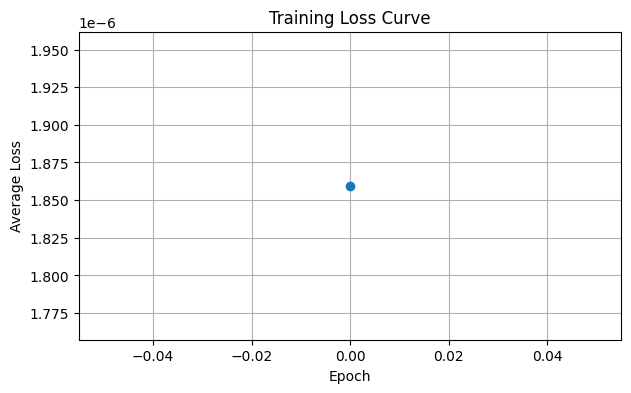

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()